**This is a preliminary ML script to determine the best models for our project data.**

Naive Bayes Overview:
"...if we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.  Different types of naive Bayes classifiers rest on different naive assumptions about the data..." (VanderPlas, Jake.  Python Data Science Handbook.  O'Reilly Media, Inc.: 2016.

Logistic Regression Overview:
ogistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X. (https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)

Description of Target(replace with .gov source in final notebook, this is enough to get started though): 
https://regulatorysol.com/action-taken-action-taken-date/

**Pending Additions, 8/11**
- Full set of features + one-hot encoding for categoricals. DONE
- Normalization PENDING
- Full set of models PRELIMINARY PENDING SVM
- Review of precision and recall, visualizations PRELIMINARY PENDING SVM
- Most informative features PENDING
- Next steps PENDING


In [1]:
%matplotlib inline

import os
import json
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

**Import 2017 sample of 25,000 observations.**  Note import warning:"Columns (29,30,39,40) have mixed types. Specify dtype option on import or set low_memory=False."

In [3]:
# Fetch the data if required
filepath = os.path.abspath(os.path.join( "..", "fixtures", "hmda2017sample.csv"))
DATA = pd.read_csv(filepath)
DATA.describe(include='all')

C:\Users\akx00\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (29,30,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,tract_to_msamd_income,rate_spread,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,...,applicant_sex_name,applicant_race_name_5,applicant_race_name_4,applicant_race_name_3,applicant_race_name_2,applicant_race_name_1,applicant_ethnicity_name,agency_name,agency_abbr,action_taken_name
count,25000.000000,25000.000000,848.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.00000,21758.000000,...,25000,2,5,11,145,25000,25000,25000,25000,25000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,1,3,4,5,7,4,6,6,7
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Male,White,White,White,White,White,Not Hispanic or Latino,Department of Housing and Urban Development,HUD,Loan originated
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14027,2,2,5,111,16162,16986,12276,12276,12754
mean,12499.500000,111.397555,2.502830,5713.388400,31.196988,1453.986800,1983.270800,236.43560,70736.62400,105.568435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,7217.022701,40.126879,1.468485,3294.295145,26.444629,890.954715,1096.396276,826.32896,13831.63976,142.214077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,1.500000,0.000000,0.000000,0.000000,0.000000,1.00000,15800.00000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,6249.750000,85.459999,1.670000,3824.000000,10.090000,919.000000,1340.750000,107.00000,62100.00000,50.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,12499.500000,106.370003,1.940000,5124.500000,22.080000,1320.000000,1813.000000,180.00000,69200.00000,78.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,18749.250000,131.699997,2.515000,6766.000000,46.299999,1791.000000,2387.000000,281.00000,75700.00000,120.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Drop features which are redundant or have mostly missing data + Drop first column
ALSO: drop census_tract_number b/c it makes each bin of data too granular; less predictive power**

In [4]:
DATA = DATA.drop(DATA.columns[0], axis=1)

DATA = DATA.drop(['rate_spread', 
        'state_name', 
        'sequence_number', 
        'respondent_id', 
        'edit_status_name', 
        'denial_reason_name_3', 
        'denial_reason_name_2', 
        'denial_reason_name_1', 
        'co_applicant_race_name_5', 
        'co_applicant_race_name_4', 
        'co_applicant_race_name_3', 
        'co_applicant_race_name_2',
        'census_tract_number',
        'application_date_indicator', 
        'applicant_race_name_5', 
        'applicant_race_name_4', 
        'applicant_race_name_3', 
        'applicant_race_name_2', 
        'agency_name'], 
        axis=1)


**Write the initial script using subset of features which are already int or float, plus the target** Future version of script will address full set of features, and will move away from use of the lambda function for readability.

**IDEAS: discard file closed, call 'application approved but not accepted" a 1 or discard, discard 'application withdrawn by applicant'.  Concern about overfitting if we leave too much stuff in.  
ACTION: One year - test with these different ideas.  Test across different years. Different team members.**

In [5]:
DATA['action_taken'] = DATA.action_taken_name.apply(lambda x: 1 if x in ['Loan purchased by the institution', 'Loan originated'] else 0)
pd.crosstab(DATA['action_taken_name'],DATA['action_taken'], margins=True)

action_taken,0,1,All
action_taken_name,,,
Application approved but not accepted,700,0,700
Application denied by financial institution,3923,0,3923
Application withdrawn by applicant,2952,0,2952
File closed for incompleteness,1096,0,1096
Loan originated,0,12754,12754
Loan purchased by the institution,0,3573,3573
Preapproval request denied by financial institution,2,0,2
All,8673,16327,25000


**ACTION: look at imputing income using hud household median income rather than mean**

In [6]:
DATA_targ_numeric = DATA[['action_taken',
            'tract_to_msamd_income', 
            'population', 
            'minority_population', 
            'number_of_owner_occupied_units', 
            'number_of_1_to_4_family_units', 
            'loan_amount_000s', 
            'hud_median_family_income', 
            'applicant_income_000s' 
            ]]
#resolve missing values in applicant_income_000s
DATA_targ_numeric.fillna(DATA_targ_numeric.mean(), inplace=True)
DATA_targ_numeric.info()
DATA_basefile = DATA_targ_numeric

C:\Users\akx00\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 9 columns):
action_taken                      25000 non-null int64
tract_to_msamd_income             25000 non-null float64
population                        25000 non-null int64
minority_population               25000 non-null float64
number_of_owner_occupied_units    25000 non-null int64
number_of_1_to_4_family_units     25000 non-null int64
loan_amount_000s                  25000 non-null int64
hud_median_family_income          25000 non-null int64
applicant_income_000s             25000 non-null float64
dtypes: float64(3), int64(6)
memory usage: 1.7 MB


**Use one-hot encoding via Pandas, concatenate to the rest of the data frame.**

NOTE: target is handled at the same time as the numeric features.

Reference link:
https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

**Make dummies for all categorical fields; append basefile**

TO-DO:
Fix varname formatting, drop census tract number (and msamd_name?), check on as of year

In [7]:
DATA = DATA.drop(['action_taken_name'], axis=1)
DATA.columns

Index(['tract_to_msamd_income', 'population', 'minority_population',
       'number_of_owner_occupied_units', 'number_of_1_to_4_family_units',
       'loan_amount_000s', 'hud_median_family_income', 'applicant_income_000s',
       'state_abbr', 'purchaser_type_name', 'property_type_name',
       'preapproval_name', 'owner_occupancy_name', 'msamd_name',
       'loan_type_name', 'loan_purpose_name', 'lien_status_name',
       'hoepa_status_name', 'county_name', 'co_applicant_sex_name',
       'co_applicant_race_name_1', 'co_applicant_ethnicity_name', 'as_of_year',
       'applicant_sex_name', 'applicant_race_name_1',
       'applicant_ethnicity_name', 'agency_abbr', 'action_taken'],
      dtype='object')

In [8]:
non_categorical_features = ['action_taken',
                        'tract_to_msamd_income', 
                        'population', 
                        'minority_population', 
                        'number_of_owner_occupied_units', 
                        'number_of_1_to_4_family_units', 
                        'loan_amount_000s', 
                        'hud_median_family_income', 
                        'applicant_income_000s'
                       ]

non_categorical_features

['action_taken',
 'tract_to_msamd_income',
 'population',
 'minority_population',
 'number_of_owner_occupied_units',
 'number_of_1_to_4_family_units',
 'loan_amount_000s',
 'hud_median_family_income',
 'applicant_income_000s']

In [9]:
for categorical_feature in list(DATA.columns):
    if categorical_feature not in non_categorical_features:
        DATA[categorical_feature] = DATA[categorical_feature].astype('category')
        dummies = pd.get_dummies(DATA[categorical_feature], prefix=categorical_feature)
        DATA_basefile = pd.concat([DATA_basefile, dummies], axis=1)
        
DATA_basefile.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 1609 columns):
action_taken                                                                                                     int64
tract_to_msamd_income                                                                                            float64
population                                                                                                       int64
minority_population                                                                                              float64
number_of_owner_occupied_units                                                                                   int64
number_of_1_to_4_family_units                                                                                    int64
loan_amount_000s                                                                                                 int64
hud_median_family_income                            

In [ ]:
tofilepath = os.path.abspath(os.path.join( "..", "fixtures", "hmda2017sample_alltest.csv"))
DATA_basefile.to_csv(tofilepath, index=False)

In [10]:
# Determine the shape of the data
print("{} instances with {} features\n".format(*DATA_basefile.shape))

# Determine the frequency of each class
print(pd.crosstab(index=DATA['action_taken'], columns="count"))

25000 instances with 1609 features

col_0         count
action_taken       
0              8673
1             16327


## Classification 


In [11]:
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

In [12]:
DATA_basefile.columns[1:]

Index(['tract_to_msamd_income', 'population', 'minority_population',
       'number_of_owner_occupied_units', 'number_of_1_to_4_family_units',
       'loan_amount_000s', 'hud_median_family_income', 'applicant_income_000s',
       'state_abbr_AL', 'state_abbr_AR',
       ...
       'applicant_ethnicity_name_Hispanic or Latino',
       'applicant_ethnicity_name_Information not provided by applicant in mail, Internet, or telephone application',
       'applicant_ethnicity_name_Not Hispanic or Latino',
       'applicant_ethnicity_name_Not applicable', 'agency_abbr_CFPB',
       'agency_abbr_FDIC', 'agency_abbr_FRS', 'agency_abbr_HUD',
       'agency_abbr_NCUA', 'agency_abbr_OCC'],
      dtype='object', length=1608)

In [13]:
X = DATA_basefile[DATA_basefile.columns[1:]]
y = DATA_basefile['action_taken']

In [14]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    #NOTE: for capstone add X_test, X_train, Y_test, Y_train for capstone code.  
    #Bake into model to see if it does cross validation, if not there do CV.
    '''y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])'''

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [18]:
# Try them all!
models = [
    GaussianNB(), 
    LogisticRegression(solver='lbfgs', max_iter=4000), 
    LogisticRegressionCV(cv=3, max_iter=4000), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]
for model in models:
    score_model(X, y, model)

GaussianNB: 0.8705070384037175
LogisticRegression: 0.7896299902629016
LogisticRegressionCV: 0.7977398354010564
BaggingClassifier: 0.9931650246305419
ExtraTreesClassifier: 0.999969374942578
RandomForestClassifier: 0.9999693768182515


In [ ]:
svc_models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC()
    ]

for model in svc_models:
    score_model(X, y, model)

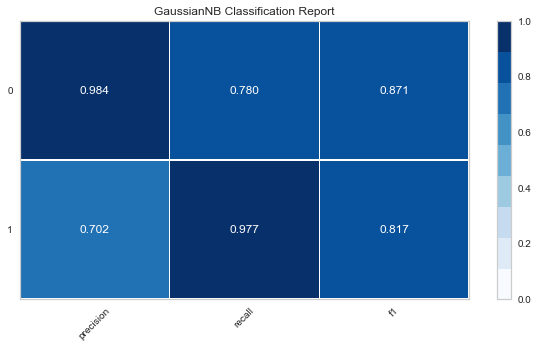

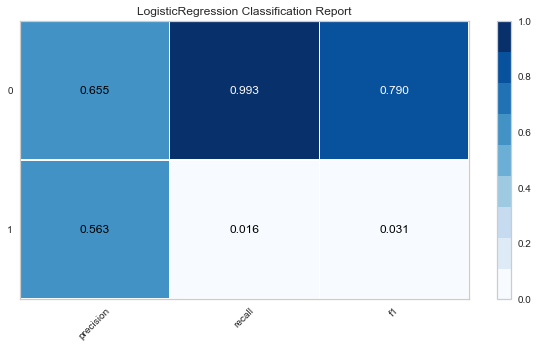

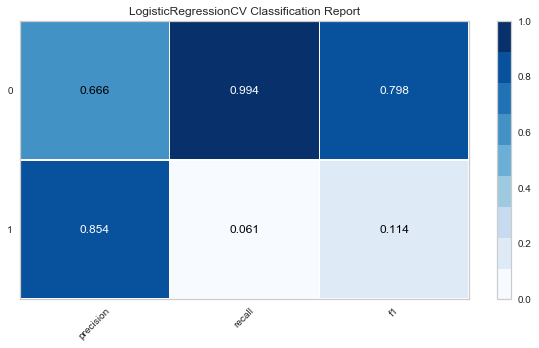

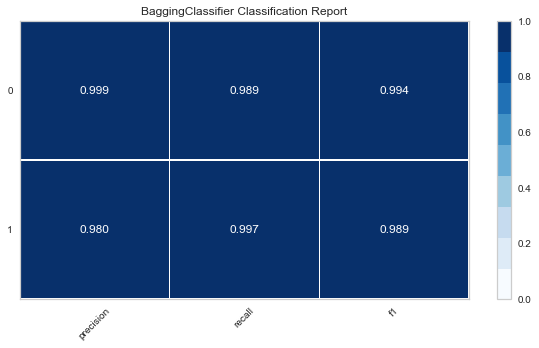

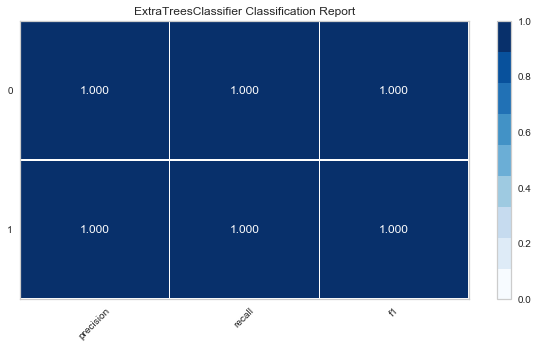

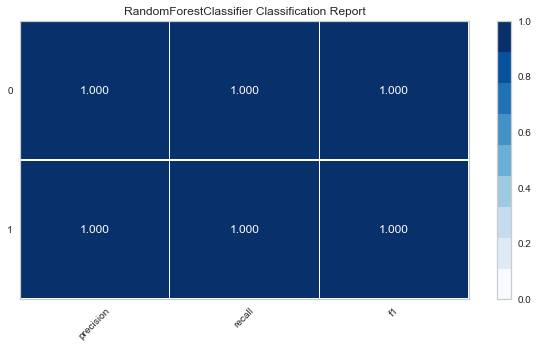

In [19]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=[1,0], 
        cmap="Blues", size=(600, 360)
    )
    visualizer.fit(X, y)  
    visualizer.score(X, y)
    visualizer.poof()  

for model in models:
    visualize_model(X, y, model)